# KNN Classification dengan HSV + LBP Combined Features + Optuna Tuning

In [32]:
import os
import json
import time
import warnings
import numpy as np
import pandas as pd
import cv2
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score

try:
    from skimage.feature import local_binary_pattern
    SKIMAGE_AVAILABLE = True
except ImportError:
    SKIMAGE_AVAILABLE = False
    print('Warning: skimage not available, using fallback LBP')

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [33]:
class Config:
    TRAIN_DIR = '/kaggle/input/biji-kopi/train'
    VAL_DIR = '/kaggle/input/biji-kopi/valid'
    TEST_DIR = '/kaggle/input/biji-kopi/test'
    IMG_SIZE = 224
    HSV_BINS = (8, 8, 8)
    LBP_RADIUS = 2
    LBP_POINTS = 16
    OPTUNA_TRIALS = 50
    RANDOM_STATE = 42
    OUTPUT_DIR = './output_knn_hsv_lbp_optuna'
    NUM_CLASSES = 54

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [34]:
class FeatureExtractorHSV:
    def __init__(self, img_size=224, hsv_bins=(8, 8, 8)):
        self.img_size = img_size
        self.hsv_bins = hsv_bins
    
    def extract_hsv_hist(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, self.hsv_bins, 
                           [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    
    def extract(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        return self.extract_hsv_hist(img)

In [35]:
class FeatureExtractorLBP:
    def __init__(self, img_size=224, radius=2, n_points=16):
        self.img_size = img_size
        self.radius = radius
        self.n_points = n_points
        self.n_bins = n_points + 2
    
    def compute_lbp(self, image_gray):
        if SKIMAGE_AVAILABLE:
            lbp = local_binary_pattern(image_gray, self.n_points, self.radius, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.n_bins + 1), 
                                   range=(0, self.n_bins))
        else:
            h, w = image_gray.shape
            lbp_image = np.zeros_like(image_gray)
            for i in range(1, h-1):
                for j in range(1, w-1):
                    center = image_gray[i, j]
                    code = 0
                    code |= (image_gray[i-1, j-1] >= center) << 7
                    code |= (image_gray[i-1, j] >= center) << 6
                    code |= (image_gray[i-1, j+1] >= center) << 5
                    code |= (image_gray[i, j+1] >= center) << 4
                    code |= (image_gray[i+1, j+1] >= center) << 3
                    code |= (image_gray[i+1, j] >= center) << 2
                    code |= (image_gray[i+1, j-1] >= center) << 1
                    code |= (image_gray[i, j-1] >= center) << 0
                    lbp_image[i, j] = code
            hist, _ = np.histogram(lbp_image.ravel(), bins=256, range=(0, 256))
        
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)
        return hist
    
    def extract(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size))
        return self.compute_lbp(img)

In [36]:
class CombinedFeatureExtractor:
    def __init__(self, hsv_extractor, lbp_extractor):
        self.hsv_extractor = hsv_extractor
        self.lbp_extractor = lbp_extractor
    
    def extract(self, image_path):
        fitur_hsv = self.hsv_extractor.extract(image_path)
        fitur_lbp = self.lbp_extractor.extract(image_path)
        return np.concatenate([fitur_hsv, fitur_lbp])
    
    def extract_from_directory(self, directory):
        features = []
        labels = []
        class_names = sorted(os.listdir(directory))
        
        for class_name in class_names:
            class_path = os.path.join(directory, class_name)
            if not os.path.isdir(class_path):
                continue
            
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in tqdm(image_files, desc=f'{class_name}', leave=False):
                img_path = os.path.join(class_path, img_file)
                feature = self.extract(img_path)
                features.append(feature)
                labels.append(class_name)
        
        return np.array(features), np.array(labels), class_names

In [37]:
hsv_ext = FeatureExtractorHSV(img_size=Config.IMG_SIZE, hsv_bins=Config.HSV_BINS)
lbp_ext = FeatureExtractorLBP(img_size=Config.IMG_SIZE, 
                              radius=Config.LBP_RADIUS, 
                              n_points=Config.LBP_POINTS)
combined_ext = CombinedFeatureExtractor(hsv_ext, lbp_ext)

print('Ekstraksi fitur gabungan train...')
X_train, y_train, class_names = combined_ext.extract_from_directory(Config.TRAIN_DIR)

print('Ekstraksi fitur gabungan validation...')
X_val, y_val, _ = combined_ext.extract_from_directory(Config.VAL_DIR)

print('Ekstraksi fitur gabungan test...')
X_test, y_test, _ = combined_ext.extract_from_directory(Config.TEST_DIR)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hitung dimensi tiap fitur
hsv_dim = np.prod(Config.HSV_BINS)
lbp_dim = Config.LBP_POINTS + 2

print(f'\nTrain: {len(X_train_scaled)} | Val: {len(X_val_scaled)} | Test: {len(X_test_scaled)}')
print(f'Dimensi HSV: {hsv_dim} | Dimensi LBP: {lbp_dim} | Total: {X_train_scaled.shape[1]}')
print(f'Jumlah kelas: {len(label_encoder.classes_)}')

Ekstraksi fitur gabungan train...


Arabika Aceh Gayo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/120 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/148 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

Ekstraksi fitur gabungan validation...


Arabika Aceh Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/16 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/18 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Ekstraksi fitur gabungan test...


Arabika Aceh Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/13 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/21 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]


Train: 7236 | Val: 918 | Test: 918
Dimensi HSV: 512 | Dimensi LBP: 18 | Total: 530
Jumlah kelas: 54


In [38]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train_enc)
    y_pred_val = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val_enc, y_pred_val)
    
    return accuracy

In [39]:
print(f'Memulai Optuna tuning dengan {Config.OPTUNA_TRIALS} trials...')
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=Config.RANDOM_STATE)
)

study.optimize(objective, n_trials=Config.OPTUNA_TRIALS, show_progress_bar=True)

print(f'\nBest validation accuracy: {study.best_value:.4f}')
print('Best params:', study.best_params)

Memulai Optuna tuning dengan 50 trials...


  0%|          | 0/50 [00:00<?, ?it/s]


Best validation accuracy: 0.6514
Best params: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}


In [46]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

In [41]:
best_params = study.best_params
final_model = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric'],
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train_enc)

# Simpan model dan preprocessor
joblib.dump(final_model, os.path.join(Config.OUTPUT_DIR, 'knn_model_combined_optuna.pkl'))
joblib.dump(scaler, os.path.join(Config.OUTPUT_DIR, 'scaler_combined_optuna.pkl'))
joblib.dump(label_encoder, os.path.join(Config.OUTPUT_DIR, 'label_encoder_combined_optuna.pkl'))

print('Model final dengan best params berhasil dilatih dan disimpan.')

Model final dengan best params berhasil dilatih dan disimpan.


In [42]:
y_pred = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)

top1_accuracy = accuracy_score(y_test_enc, y_pred)
top5_accuracy = top_k_accuracy_score(y_test_enc, y_proba, k=5, labels=range(len(label_encoder.classes_)))
macro_f1 = f1_score(y_test_enc, y_pred, average='macro')

print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
print(f'Macro F1-Score: {macro_f1:.4f}')
print('\n--- Classification Report ---')
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_, digits=4))

Top-1 Accuracy: 0.6612
Top-5 Accuracy: 0.8943
Macro F1-Score: 0.6516

--- Classification Report ---
                                 precision    recall  f1-score   support

              Arabika Aceh Gayo     0.8333    0.8824    0.8571        17
              Arabika Argo Puro     0.6471    0.6471    0.6471        17
       Arabika Arjuno Budug Asu     0.7000    0.8235    0.7568        17
         Arabika Bali Batu Karu     0.5833    0.4118    0.4828        17
         Arabika Bali Kintamani     0.7692    0.5882    0.6667        17
             Arabika Bali Ulian     0.4231    0.6471    0.5116        17
          Arabika Dolok Sanggul     0.3750    0.3529    0.3636        17
               Arabika Enrekang     0.3636    0.2353    0.2857        17
          Arabika Flores Bajawa     0.8750    0.8235    0.8485        17
       Arabika Flores Manggarai     0.6154    0.4706    0.5333        17
      Arabika Golosera Wae Rebo     0.6154    0.9412    0.7442        17
                   Arab

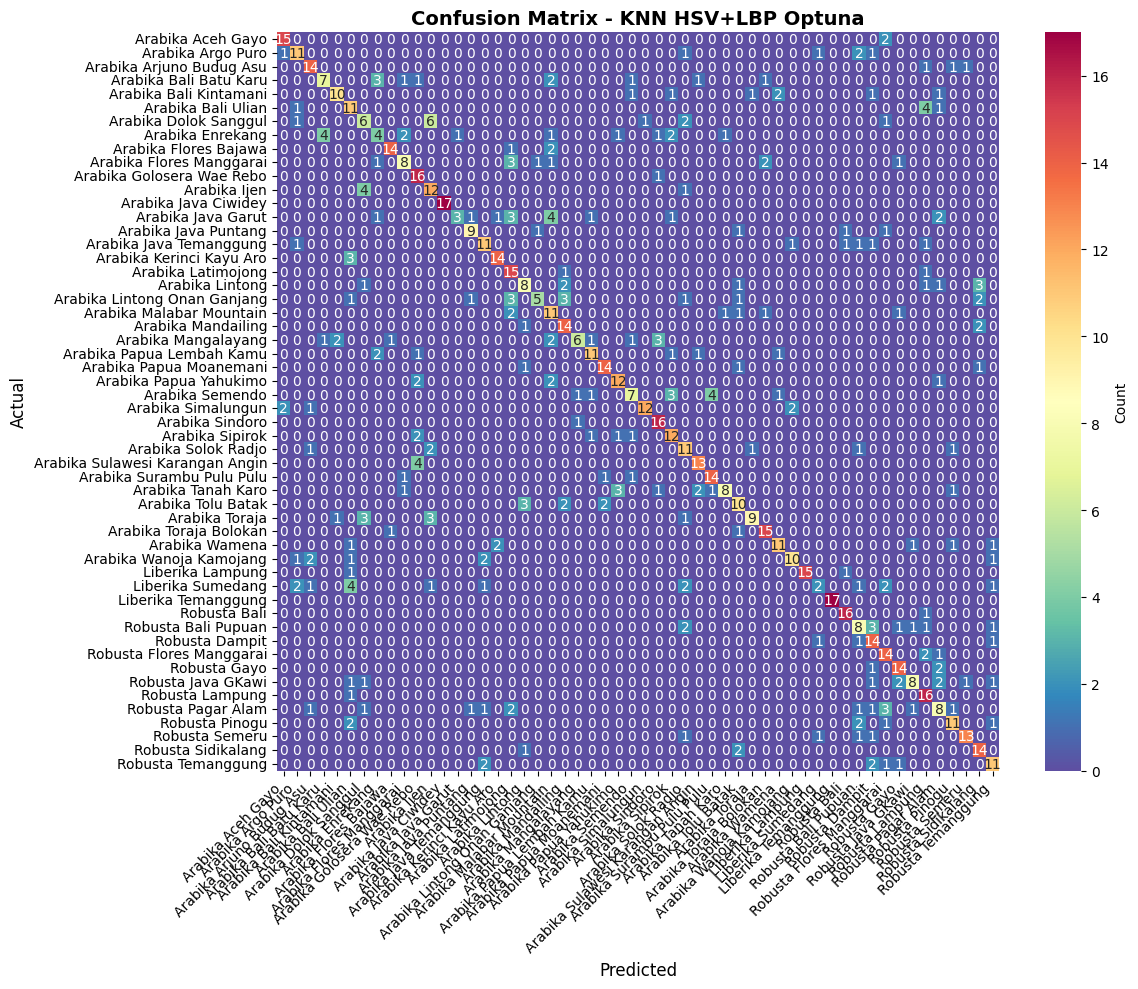

In [43]:
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(15, 13))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral_r', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - KNN HSV+LBP Optuna', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'confusion_matrix_hsv_lbp.png'), dpi=150, bbox_inches='tight')
plt.show()

In [44]:
per_class_acc = []
for i, class_name in enumerate(label_encoder.classes_):
    mask = y_test_enc == i
    total = mask.sum()
    if total > 0:
        correct = (y_pred[mask] == i).sum()
        acc = correct / total
        per_class_acc.append({
            'Class': class_name,
            'Accuracy': acc,
            'Samples': total
        })

df_per_class = pd.DataFrame(per_class_acc)
df_per_class = df_per_class.sort_values('Accuracy', ascending=False)
df_per_class.to_csv(os.path.join(Config.OUTPUT_DIR, 'per_class_hsv_lbp.csv'), index=False)

print(df_per_class.to_string(index=False))

                          Class  Accuracy  Samples
           Arabika Java Ciwidey  1.000000       17
            Liberika Temanggung  1.000000       17
                Robusta Lampung  0.941176       17
                   Robusta Bali  0.941176       17
                Arabika Sindoro  0.941176       17
      Arabika Golosera Wae Rebo  0.941176       17
              Arabika Aceh Gayo  0.882353       17
             Arabika Latimojong  0.882353       17
         Arabika Toraja Bolokan  0.882353       17
               Liberika Lampung  0.882353       17
       Arabika Kerinci Kayu Aro  0.823529       17
             Arabika Mandailing  0.823529       17
                   Robusta Gayo  0.823529       17
                 Robusta Dampit  0.823529       17
        Arabika Papua Moanemani  0.823529       17
      Arabika Surambu Pulu Pulu  0.823529       17
          Arabika Flores Bajawa  0.823529       17
       Arabika Arjuno Budug Asu  0.823529       17
       Robusta Flores Manggarai

In [45]:
final_results = {
    'model': 'KNN_HSV_LBP_Optuna',
    'num_classes': Config.NUM_CLASSES,
    'feature_dim': int(X_train.shape[1]),
    'hsv_bins': list(Config.HSV_BINS),
    'hsv_dim': int(hsv_dim),
    'lbp_radius': Config.LBP_RADIUS,
    'lbp_points': Config.LBP_POINTS,
    'lbp_dim': int(lbp_dim),
    'optuna_trials': Config.OPTUNA_TRIALS,
    'best_params': study.best_params,
    'best_val_accuracy': float(study.best_value),
    'top1_accuracy': float(top1_accuracy),
    'top5_accuracy': float(top5_accuracy),
    'macro_f1': float(macro_f1),
    'train_samples': int(len(y_train)),
    'val_samples': int(len(y_val)),
    'test_samples': int(len(y_test))
}

results_path = os.path.join(Config.OUTPUT_DIR, 'final_results_hsv_lbp.json')
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f'Hasil final disimpan ke: {results_path}')
print('\n=== Summary ===')
for key, value in final_results.items():
    if key != 'best_params':
        print(f'{key}: {value}')
print(f"best_params: {final_results['best_params']}")

Hasil final disimpan ke: ./output_knn_hsv_lbp_optuna/final_results_hsv_lbp.json

=== Summary ===
model: KNN_HSV_LBP_Optuna
num_classes: 54
feature_dim: 530
hsv_bins: [8, 8, 8]
hsv_dim: 512
lbp_radius: 2
lbp_points: 16
lbp_dim: 18
optuna_trials: 50
best_val_accuracy: 0.6514161220043573
top1_accuracy: 0.6612200435729847
top5_accuracy: 0.8943355119825708
macro_f1: 0.6515504029852232
train_samples: 7236
val_samples: 918
test_samples: 918
best_params: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}
